# Prognoza temperatury SARIMAX

SARIMAX to model statystyczny do przewidywania szeregów czasowych (np. temperatury), który bierze pod uwagę trzy rzeczy: przeszłość, cykliczność (sezony) i dodatkowe dane zewnętrzne.

Parametry modelu zapisujemy jako `(p, d, q) x (P, D, Q, s)`:

* **AR (p/P): autoregressive.** Patrzymy wstecz. "Skoro godzinę temu było ciepło, to teraz pewnie też będzie". p - ile ostatnich obserwacji bierzemy pod uwagę. P – to samo, ale w skali sezonu (np ile ostatnich miesięcy)
* **I (d/D): integrated.** modeluje różnice między kolejnymi pomiarami, żeby usunąć trend.
* **MA (q/Q): moving average.** Uczenie się na błędach prognoz z poprzednich kroków. "Jeśli godzinę temu pomyliłem się o 2 stopnie, teraz biorę poprawkę".
* **s (Seasonality):** Długość cyklu. Tu cykl dobowy, ale `s` zależy od resamplingu (dla danych co 3h, s=8, bo 8*3=24h).
* **X (Exogenous):** Zmienne zewnętrzne (np. wilgotność, ciśnienie). muszą być znane w momencie prognozy

#### Warianty prognozy

1. **Krok co 2h/3h/4h** - model prognozuje temperaturę co 4 godziny, ewaluacja na takim samum formacji danych
2. **Krok 12h (dzień / noc)** - dane są agregowane do okresów:
   * dzień: 06:00-18:00
   * noc: 18:00-06:00
     Model prognozuje bezpośrednio średnią temperaturę dla dnia lub nocy.

#### Przygotowanie danych (Feature Engineering)

Dane przeskalowane (`StandardScaler`), zagregowane (resampling co 2h lub 3h lub 4h).

**Stworzone kolumny (exog):**

* `climatology`: Średnia temperatura z przeszłości dla tego konkretnego dnia w roku (expanding mean).
* `day_year_sin` / `day_year_cos`: Cykliczna reprezentacja daty (dzięki temu model wie, że 31 grudnia jest blisko 1 stycznia).
* `*_lag1` (np. `pres_lag1`, `rhum_lag1`): Wartość ciśnienia/wilgotności z *poprzedniego* kroku.
* `*_trend` (np. `pres_trend`): Szybkość zmiany (różnica między wartością sprzed 1 a 2 kroków).
* `dew_point_approx_lag1`: Przybliżony punkt rosy obliczony z temperatury i wilgotności.

#### Podział danych i ewaluacja

* **Podział danych**:
  * train: dane historyczne od 2023 (bo sarima jest dość wolna), ale z `climatology` policzonym również na podstawie wcześniejszych rekordów
  * test: ostatni rok danych,
* **Metryki jakości**:
  * MAE,
  * RMSE,
  * R2,
* Dla kroku 12h metryki liczone osobno dla **dnia i nocy**, (do sensownego porównania z xgboostem)

#### predykcja w SARIMAX

Prognoza przez `get_forecast()`:

* model generuje prognozę rekurencyjnie na kolejne kroki czasowe,
* nie widzi żadnych rzeczywistych danych z przyszłości,
* korzysta tylko z danych historycznych i zadanych exog i tego co już sam przewidział.

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler


plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path('data')

df_clean = pd.read_csv(DATA_DIR / 'combined.csv', parse_dates=['time'], index_col='time')

In [17]:
df=df_clean.copy()
RESAMPLE_I,RESAMPLE_S = 3,"3h"
# RESAMPLE_I,RESAMPLE_S = 4,"4h"
# RESAMPLE_I,RESAMPLE_S = 6,"6h"
# expanding mean from temt from the past for this day of year
df = df.sort_index()
df["doy"] = df.index.dayofyear
df["climatology"] = (
    df
    .groupby("doy")["temp"]
    .transform(lambda s: s.expanding().mean().shift(1))
)

df = df.dropna(subset=["climatology"])

df = df.loc["2023-01-01":]
df = df.resample(RESAMPLE_S).mean()

df['pres_lag1'] = df['pres'].shift(1)
df['rhum_lag1'] = df['rhum'].shift(1)
df['cldc_lag1'] = df['cldc'].shift(1)
df['wspd_lag1'] = df['wspd'].shift(1)
df['prcp_lag1'] = df['prcp'].shift(1)

df['pres_trend'] = df['pres'].shift(1) - df['pres'].shift(2)
df['temp_trend'] = df['temp'].shift(1) - df['temp'].shift(2)
df['prcp_trend'] = df['prcp'].shift(1) - df['prcp'].shift(2)
df['dew_point_approx_lag1'] = (
    df['temp'].shift(1) - ((100 - df['rhum'].shift(1)) / 5)
)
df['day_year_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
df['day_year_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)

df = df.dropna()

test_hours = 24//RESAMPLE_I * 365
train, test = df.iloc[:-test_hours], df.iloc[-test_hours:]

print(f"Train set: {train.index.min().date()} to {train.index.max().date()}")
print(f"Test set: {test.index.min().date()} to {test.index.max().date()}")

Train set: 2023-01-01 to 2024-12-31
Test set: 2024-12-31 to 2025-12-31


In [18]:
exog_cols = [
    "day_year_sin",
    "day_year_cos",
    "climatology",
    "pres_lag1",
    "rhum_lag1",
    "cldc_lag1",
    # "wspd_lag1",
    # "prcp_lag1",
    "pres_trend",
    "dew_point_approx_lag1",
]
target_col = "temp"

y_train = train[target_col]
y_test = test[target_col]

exog_train = train[exog_cols]
exog_test = test[exog_cols]

scaler = StandardScaler()
exog_train = scaler.fit_transform(exog_train)
exog_test = scaler.transform(exog_test)


In [19]:
s= 24 / RESAMPLE_I
model = SARIMAX(
    y_train,
    exog=exog_train,
    # v1
    # order=(2, 0, 1),
    # seasonal_order=(1, 0, 1, s),  # s=24/3=8
    # v2
    # order=(2, 0, 2),
    # seasonal_order=(1, 0, 1, s),
    # v3
    order=(3, 0, 1),
    seasonal_order=(1, 0, 1, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

result = model.fit(disp=False, maxiter=50)

forecast = result.get_forecast(steps=len(y_test), exog=exog_test)

y_pred = forecast.predicted_mean
y_pred.name = "temp_pred"

print(result.summary())

/home/werka/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                              temp   No. Observations:                 5839
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 8)   Log Likelihood               -9838.387
Date:                           Sun, 08 Feb 2026   AIC                          19706.774
Time:                                   18:25:34   BIC                          19806.830
Sample:                               01-01-2023   HQIC                         19741.571
                                    - 12-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0043      0.162     -0.027      0.979      -0.321       0.313
x2            -0.8157      0.183     -4.451

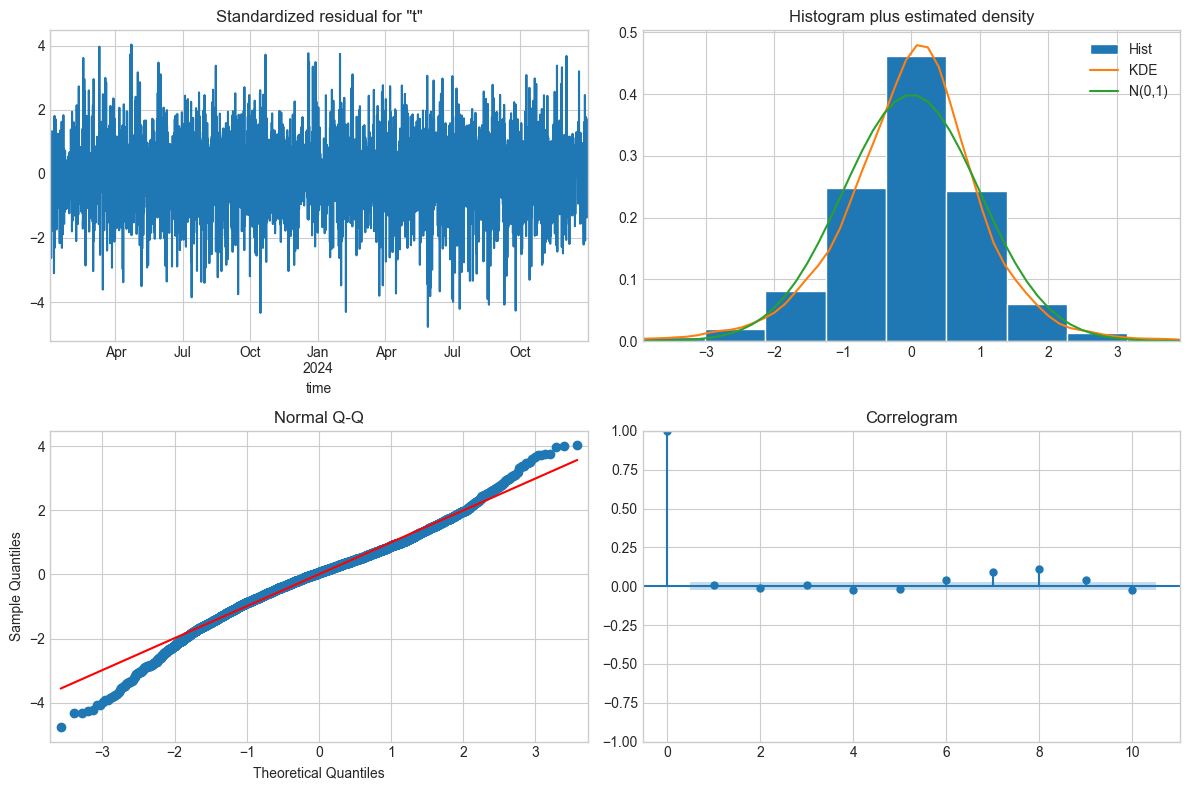

In [21]:
result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()


#### plot_diagnostics() - po co i co pokazuje

Analizujemy **reszty** (błędy modelu).

* *Cel:* Reszty mają wyglądać jak **biały szum** (losowy chaos).
* *Panel 1 (Residuals):* Brak widocznych trendów i falowania.
* *Panel 2 (Histogram):* Powinien przypominać dzwon (rozkład normalny) z górką w zerze.
* *Panel 3 (Q-Q Plot):* Kropki powinny leżeć na czerwonej linii. Odchylenia na końcach oznaczają trudności z ekstremalnymi zjawiskami.
* *Panel 4 (ACF):* Słupki korelacji powinny być blisko 0. Jeśli wystają - model pominął jakąś zależność czasową.

W moim przypadku:

* reszty są bliskie białemu szumowi,
* brak istotnej autokorelacji,
* czyli w miarę ok

### Ewaluacja na takich agregacjach jak model był trenowany

In [22]:
def eval_native(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }
native_metrics = eval_native(y_test, y_pred)
print("NATIVE EVALUATION")
for k, v in native_metrics.items():
    print(f"{k}: {v:.4f}")


NATIVE EVALUATION
MAE: 1.5331
RMSE: 2.0329
R2: 0.9378


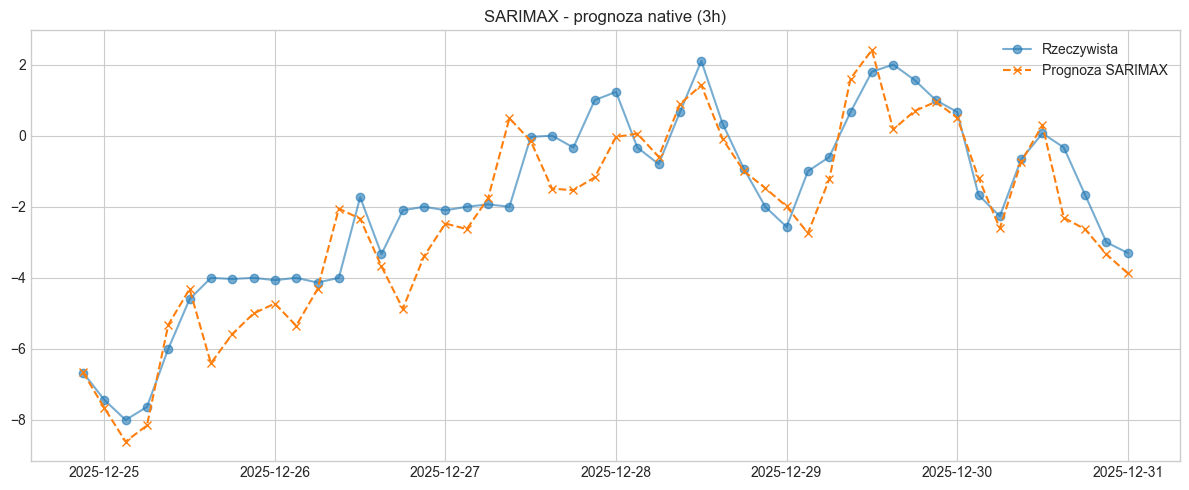

In [23]:
def plot_results_sarima(y_test,y_pred,subset=120, resample=RESAMPLE_S):
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(
        y_test.index[-subset:],
        y_test.values[-subset:],
        "o-",
        label="Rzeczywista",
        alpha=0.6,
    )
    ax.plot(
        y_pred.index[-subset:],
        y_pred.values[-subset:],
        "x--",
        label="Prognoza SARIMAX",
    )

    ax.set_title(f"SARIMAX - prognoza native ({resample})")
    ax.legend()
    plt.tight_layout()
    plt.show()
plot_results_sarima(y_test,y_pred,subset=50)

### Agregacje day/night

In [24]:
df_eval = pd.concat([y_test, y_pred], axis=1).dropna()

df_eval["hour"] = df_eval.index.hour
df_eval["date"] = df_eval.index.date

def day_night_agg(df, col):
    day_mask = df.index.hour.isin(range(6,18))

    day = df.loc[day_mask, col].mean()
    night = df.loc[~day_mask, col].mean()

    return pd.Series({
        "day": day,
        "night": night
    })

true_agg = (
    df_eval.groupby(df_eval.index.date)
    .apply(day_night_agg, col="temp")
)
pred_agg = (
    df_eval.groupby(df_eval.index.date)
    .apply(day_night_agg, col="temp_pred")
)

# Żeby nie było NaN
day_df = pd.concat(
    [true_agg["day"], pred_agg["day"]],
    axis=1,
    keys=["true", "pred"]
).dropna()

night_df = pd.concat(
    [true_agg["night"], pred_agg["night"]],
    axis=1,
    keys=["true", "pred"]
).dropna()

In [25]:

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

day_rmse, day_mae = metrics(day_df["true"], day_df["pred"])
night_rmse, night_mae = metrics(night_df["true"], night_df["pred"])

print("DAY   RMSE:", day_rmse, "MAE:", day_mae)
print("NIGHT RMSE:", night_rmse, "MAE:", night_mae)


DAY   RMSE: 1.8727831610415733 MAE: 1.453969318717342
NIGHT RMSE: 1.2449239408223858 MAE: 1.0378308433462706


In [26]:
def show_results_sarima_agg(true_agg, pred_agg, subset=60):
    fig, ax = plt.subplots(2, 1, figsize=(12, 9))

    ax[0].plot(true_agg.index[-subset:], true_agg["day"].values[-subset:], "o-", label="True")
    ax[0].plot(pred_agg.index[-subset:], pred_agg["day"].values[-subset:], "x--", label="Pred")
    ax[0].set_title("Dzień")
    ax[0].legend()

    ax[1].plot(true_agg.index[-subset:], true_agg["night"].values[-subset:], "o-", label="True")
    ax[1].plot(pred_agg.index[-subset:], pred_agg["night"].values[-subset:], "x--", label="Pred")
    ax[1].set_title("Noc")
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    
# show_results_sarima_agg(true_agg, pred_agg, subset=60)


## Day / night predictions by 12h aggregations

In [27]:
df = df_clean.copy()

def period_label(ts):
    h = ts.hour
    if 6 <= h < 18:
        return ts.normalize() + pd.Timedelta(hours=6)   # dzień
    else:
        if h >= 18:
            return ts.normalize() + pd.Timedelta(hours=18)  # noc (ten sam dzień)
        else:
            return ts.normalize() - pd.Timedelta(days=1) + pd.Timedelta(hours=18)  # noc po północy


df["period_start"] = df.index.map(period_label)
agg = {
    "temp": "mean",
    "pres": "mean",
    "rhum": "mean",
    "wspd": "mean",
    "cldc": "mean",
    "prcp": "sum",   # sensowne dla opadów
}
df_12h = (
    df
    .groupby("period_start")
    .agg(agg)
    .sort_index()
)
df_12h["hour"] = df_12h.index.hour
df_12h["is_day"] = (df_12h["hour"] == 6).astype(int)
df_12h = df_12h.asfreq("12h")


df_12h["doy_sin"] = np.sin(2 * np.pi * df_12h.index.dayofyear / 365.25)
df_12h["doy_cos"] = np.cos(2 * np.pi * df_12h.index.dayofyear / 365.25)
df_12h["doy"] = df_12h.index.dayofyear

df_12h["climatology"] = (
    df_12h
    .groupby(["doy", "is_day"])["temp"]
    .transform(lambda s: s.expanding().mean().shift(1))
)
# df_12h = df_12h.dropna()
lag_cols = ["temp", "pres", "rhum", "cldc", "wspd", "prcp"]

for col in lag_cols:
    df_12h[f"{col}_lag1"] = df_12h[col].shift(1)
df_12h["temp_trend"] = df_12h["temp_lag1"] - df_12h["temp"].shift(2)
df_12h=df_12h.loc['2022-01-01':]
df_12h = df_12h.dropna()

test_records = 2 * 365
train, test = df_12h.iloc[:-test_records], df_12h.iloc[-test_records:]

print(f"Train set: {train.index.min().date()} to {train.index.max().date()}")
print(f"Test set: {test.index.min().date()} to {test.index.max().date()}")


Train set: 2022-01-01 to 2024-12-30
Test set: 2024-12-31 to 2025-12-30


/home/werka/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 2.151
RMSE: 2.663
R2: 0.886


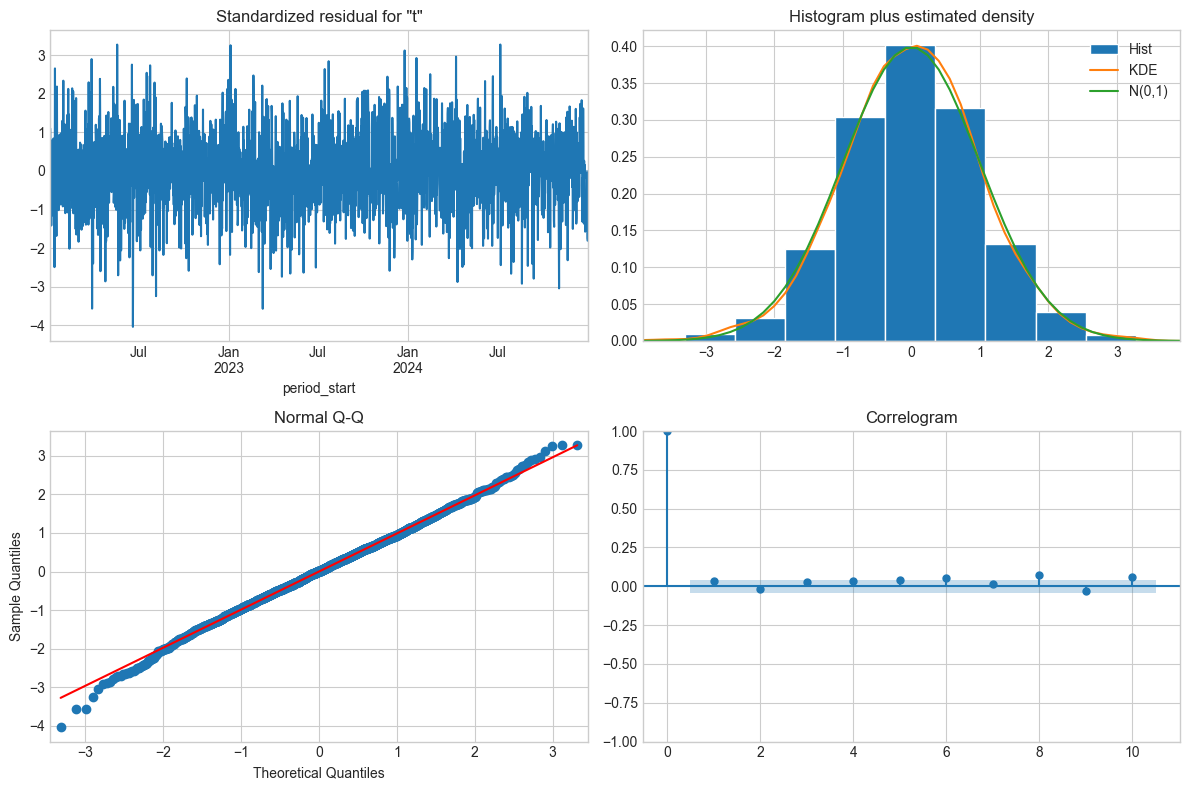

In [28]:
exog_cols = [
    "is_day",
    "doy_sin",
    "doy_cos",
    "climatology",
    "temp_lag1",
    "pres_lag1",
    "rhum_lag1",
    "cldc_lag1",
]
model = SARIMAX(
    train["temp"],
    exog=train[exog_cols],
    order=(2, 0, 1),
    seasonal_order=(0, 0, 1, 2),  # sezonowość: dzień/noc
    enforce_stationarity=False,
    enforce_invertibility=False,
)
result = model.fit(disp=False)
forecast = result.get_forecast(
    steps=len(test),
    exog=test[exog_cols]
)

y_pred = forecast.predicted_mean
mae  = mean_absolute_error(test["temp"], y_pred)
rmse = np.sqrt(mean_squared_error(test["temp"], y_pred))
r2   = r2_score(test["temp"], y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")

result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()


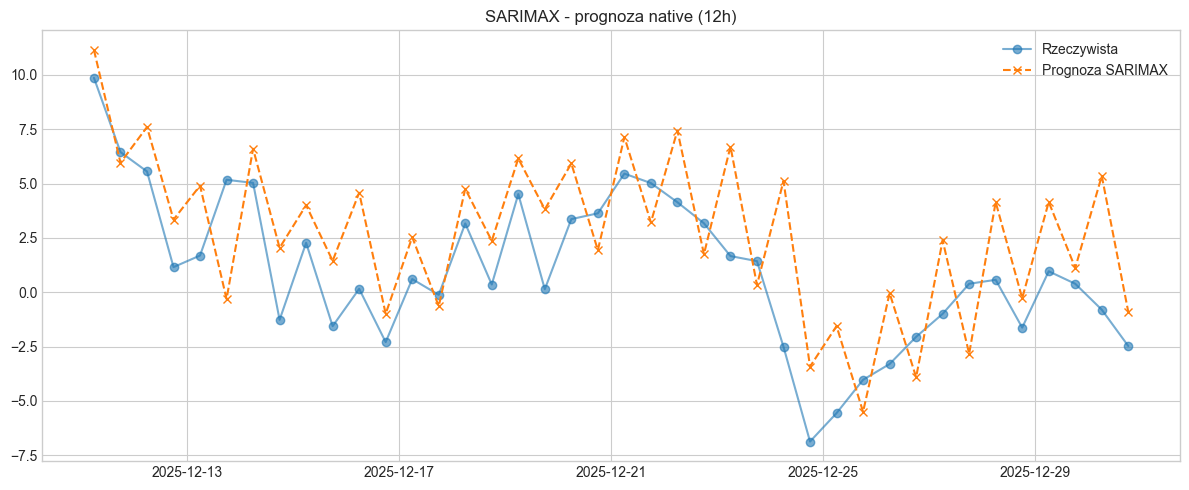

In [29]:
plot_results_sarima(test["temp"],y_pred,subset=40, resample='12h')


In [30]:
df_eval = (
    test[["temp"]]
    .rename(columns={"temp": "true"})
    .assign(pred=y_pred)
    .dropna()
)
idx = np.arange(len(df_eval))
day_df   = df_eval.iloc[idx % 2 == 0]   # parzyste
night_df = df_eval.iloc[idx % 2 == 1]   # nieparzyste
def print_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"MAE: {mae}, RMSE: {rmse}, R2: {r2}")
print(test.index[:6])

print('DAY')
print_metrics(day_df["true"], day_df["pred"])
print('NIGHT')
print_metrics(night_df["true"], night_df["pred"])

DatetimeIndex(['2024-12-31 06:00:00', '2024-12-31 18:00:00',
               '2025-01-01 06:00:00', '2025-01-01 18:00:00',
               '2025-01-02 06:00:00', '2025-01-02 18:00:00'],
              dtype='datetime64[ns]', name='period_start', freq='12h')
DAY
MAE: 2.3198347349084067, RMSE: 2.885579352922375, R2: 0.8775509120778784
NIGHT
MAE: 1.983061987054569, RMSE: 2.4195159950585188, R2: 0.8784099734455424
